# Introduction to Spark Cluster

## 1. Architecture

The architecture of Spark cluster: https://spark.apache.org/docs/latest/cluster-overview.html

![Spark Cluster architecture](https://spark.apache.org/docs/latest/img/cluster-overview.png)


## 2. Deploying the cluster on EC2

### 2.1 CloudFormation

A service to automate the configuration and deployment of complex infrastructure and applications:
https://aws.amazon.com/cloudformation/

Users prepare a description of all the components and the configuration (CF Template), and the CF deploys it, taking into account the dependencies.

Can be used to create:
* Instances
* Security gropups
* IAM Roles
* S3 buckets
* everything


### 2.2 Spark Cluster Template

The template includes:
* Two instances (Master and Worker)
* Security group
* Iam role to access S3
* Dependencies (important!) to create resources in the right order.

Configuration parameters:
* VPC: Virtual Provate Cloud (https://aws.amazon.com/vpc/) - please select the default one 
* Subnet: please select one (not important)

Outputs:
* URL to the created Master VM with the Jupyter notebook interface

The template can be visualized and edited in the designer of AWS Console: https://eu-west-1.console.aws.amazon.com/cloudformation/designer/home?region=eu-west-1

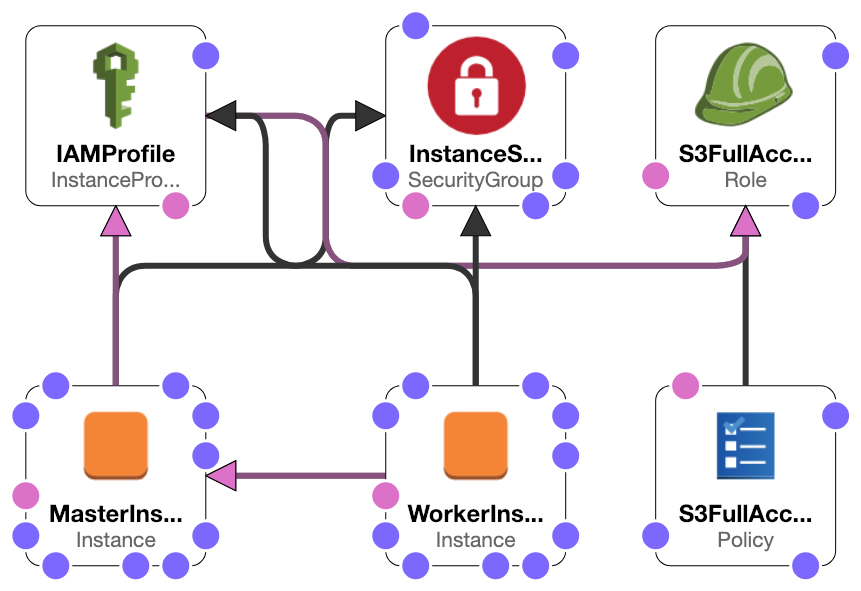

### 2.3 Launching the spark cluster 

1. Create a new stack in Cloud Formation: https://eu-west-1.console.aws.amazon.com/cloudformation/home?region=eu-west-1#/stacks/create
1. Specify template -> Upload a template file
1. Choose file: please use the provided template from the Moodle
1. Enter parameters:
  * Name: spark
  * VPC (default)
  * Subnet (any)
1. Next -> Next -> Create Stack


### 2.4 Accessing the spark cluster 

1. When a stack is ready: https://eu-west-1.console.aws.amazon.com/cloudformation/home?region=eu-west-1#/stacks we can see the output: 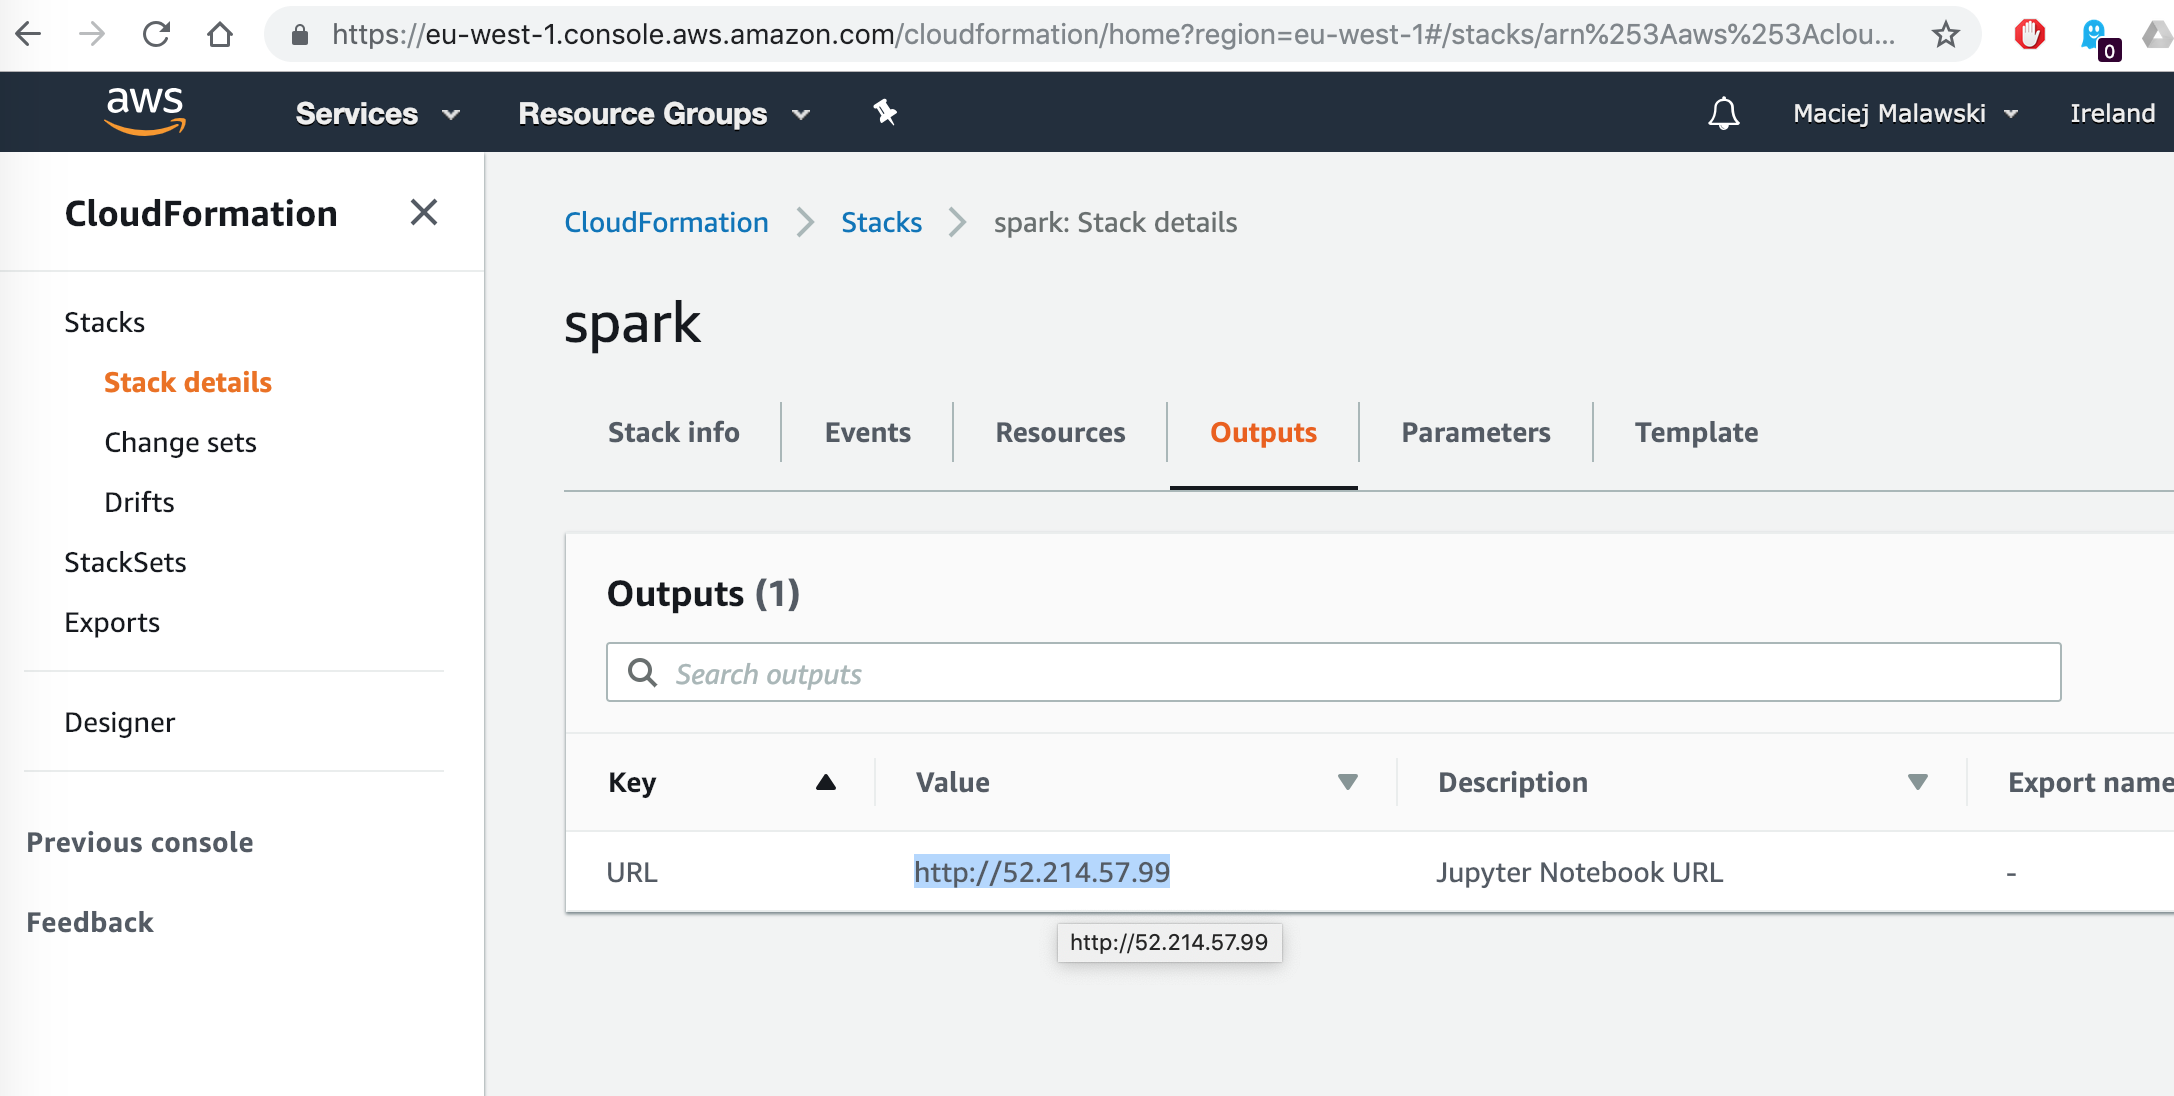
1. We can access out Jupyter notebook interface there.
1. We can monitor the Workers using the URL with port 8080.
1. We can see the SparkUI at the port 4040

## 3. Using Spark cluster from the notebook

We need to do some extra steps to connect our driver application (which is pyspark running in Jupyter kernel) to our master.

First, we need to get the internal IP address of the master

In [1]:
import socket
ipaddress=socket.gethostbyname(socket.gethostname())
print (ipaddress)

172.30.1.92


In [2]:
from pyspark.sql import SparkSession

When creating SparkSession, we need to add the URl to the master, which listens on port 7077

In [3]:
spark = SparkSession.builder.master('spark://'+ ipaddress + ':7077').\
config("spark.driver.host", ipaddress).getOrCreate()

In [4]:
spark

From now on, we can use the spark session as in a single machine scenario.

In [5]:
smog_df = spark.read.json("s3a://openaq-fetches/realtime/2019-01-31/*")

In [6]:
smog_df.printSchema()

root
 |-- attribution: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- url: string (nullable = true)
 |-- averagingPeriod: struct (nullable = true)
 |    |-- unit: string (nullable = true)
 |    |-- value: double (nullable = true)
 |-- city: string (nullable = true)
 |-- coordinates: struct (nullable = true)
 |    |-- latitude: double (nullable = true)
 |    |-- longitude: double (nullable = true)
 |-- country: string (nullable = true)
 |-- date: struct (nullable = true)
 |    |-- local: string (nullable = true)
 |    |-- utc: string (nullable = true)
 |-- location: string (nullable = true)
 |-- mobile: boolean (nullable = true)
 |-- parameter: string (nullable = true)
 |-- sourceName: string (nullable = true)
 |-- sourceType: string (nullable = true)
 |-- unit: string (nullable = true)
 |-- value: double (nullable = true)



In [7]:
smog_df.count()

675531

In [8]:
smog_df.select('parameter').distinct().toPandas()

parameter
0        bc
1       so2
2        co
3        o3
4      pm10
5       no2
6      pm25

In [9]:
smog_df.select('country').distinct().toPandas()

country
0       LT
1       FI
2       NL
3       MN
4       PL
5       MK
6       MX
7       CN
8       AD
9       HR
10      CZ
11      NP
12      PT
13      HK
14      TW
15      BD
16      CL
17      ID
18      AU
19      CA
20      UZ
21      MT
22      GB
23      KZ
24      DE
25      ES
26      BH
27      IL
28      ZA
29      US
30      RS
31      IN
32      AE
33      FR
34      CH
35      BA
36      ET
37      IT
38      SK
39      CW
40      LV
41      PE
42      XK
43      TH
44      LK
45      HU
46      SI
47      UG
48      IE
49      KW
50      BE
51      NO
52      CO
53      LU
54      VN
55      DK

In [10]:
from pyspark.sql.functions import col, asc

In [11]:
smog_df.filter(col('country')=='PL').select('city').distinct().toPandas()

city
0                Żyrardów
1                Nowa Sól
2                Jarosław
3               Guty Duże
4                   Konin
5                  Słupsk
6                Radomsko
7                  Tarnów
8                  Rybnik
9               Wałbrzych
10                Rzeszów
11                 Kielce
12              Zgorzelec
13              Widuchowa
14                 Ustroń
15                   Łódź
16                  Jasło
17           Zdzieszowice
18                  Gajew
19                 Gołdap
20              Nowy Targ
21           Jelenia Góra
22              Pabianice
23   Czerwionka-Leszczyny
24                 Kaszów
25            Złoty Potok
26                   Żory
27               Szczecin
28              Białystok
29                 Zabrze
..                    ...
108              Przemyśl
109   Gorzów Wielkopolski
110                Żywiec
111               Wschowa
112     Ząbkowice Śląskie
113               Cieszyn
114                Nowiny
115         Wieniec-Zdrój
116               Jarczew
117  Liniewko Kościerskie
118      Kędzierzyn-Koźle
119    Skarżysko-Kamienna
120               Suwałki
121               Kłodzko
122              Szymbark
123           Kościerzyna
124                Zgierz
125        Horyniec-Zdrój
126           Dzierżoniów
127                 Tychy
128            Koziegłowy
129             Florianka
130                 Opole
131                  Łeba
132              Koszalin
133             Lubliniec
134                  Żary
135             Trzebinia
136              Zielonka
137               Wrocław

[138 rows x 1 columns]

## 4. Adding more nodes to the cluster

The Spark cluster can be dynamically extended by adding more nodes.

The simplest way is to "clone" worker instances using AWS Console: https://eu-west-1.console.aws.amazon.com/ec2/v2/home?region=eu-west-1#Instances:sort=instanceId

In order to clone a Worker, we need to select it and use "Launch more like this" command:

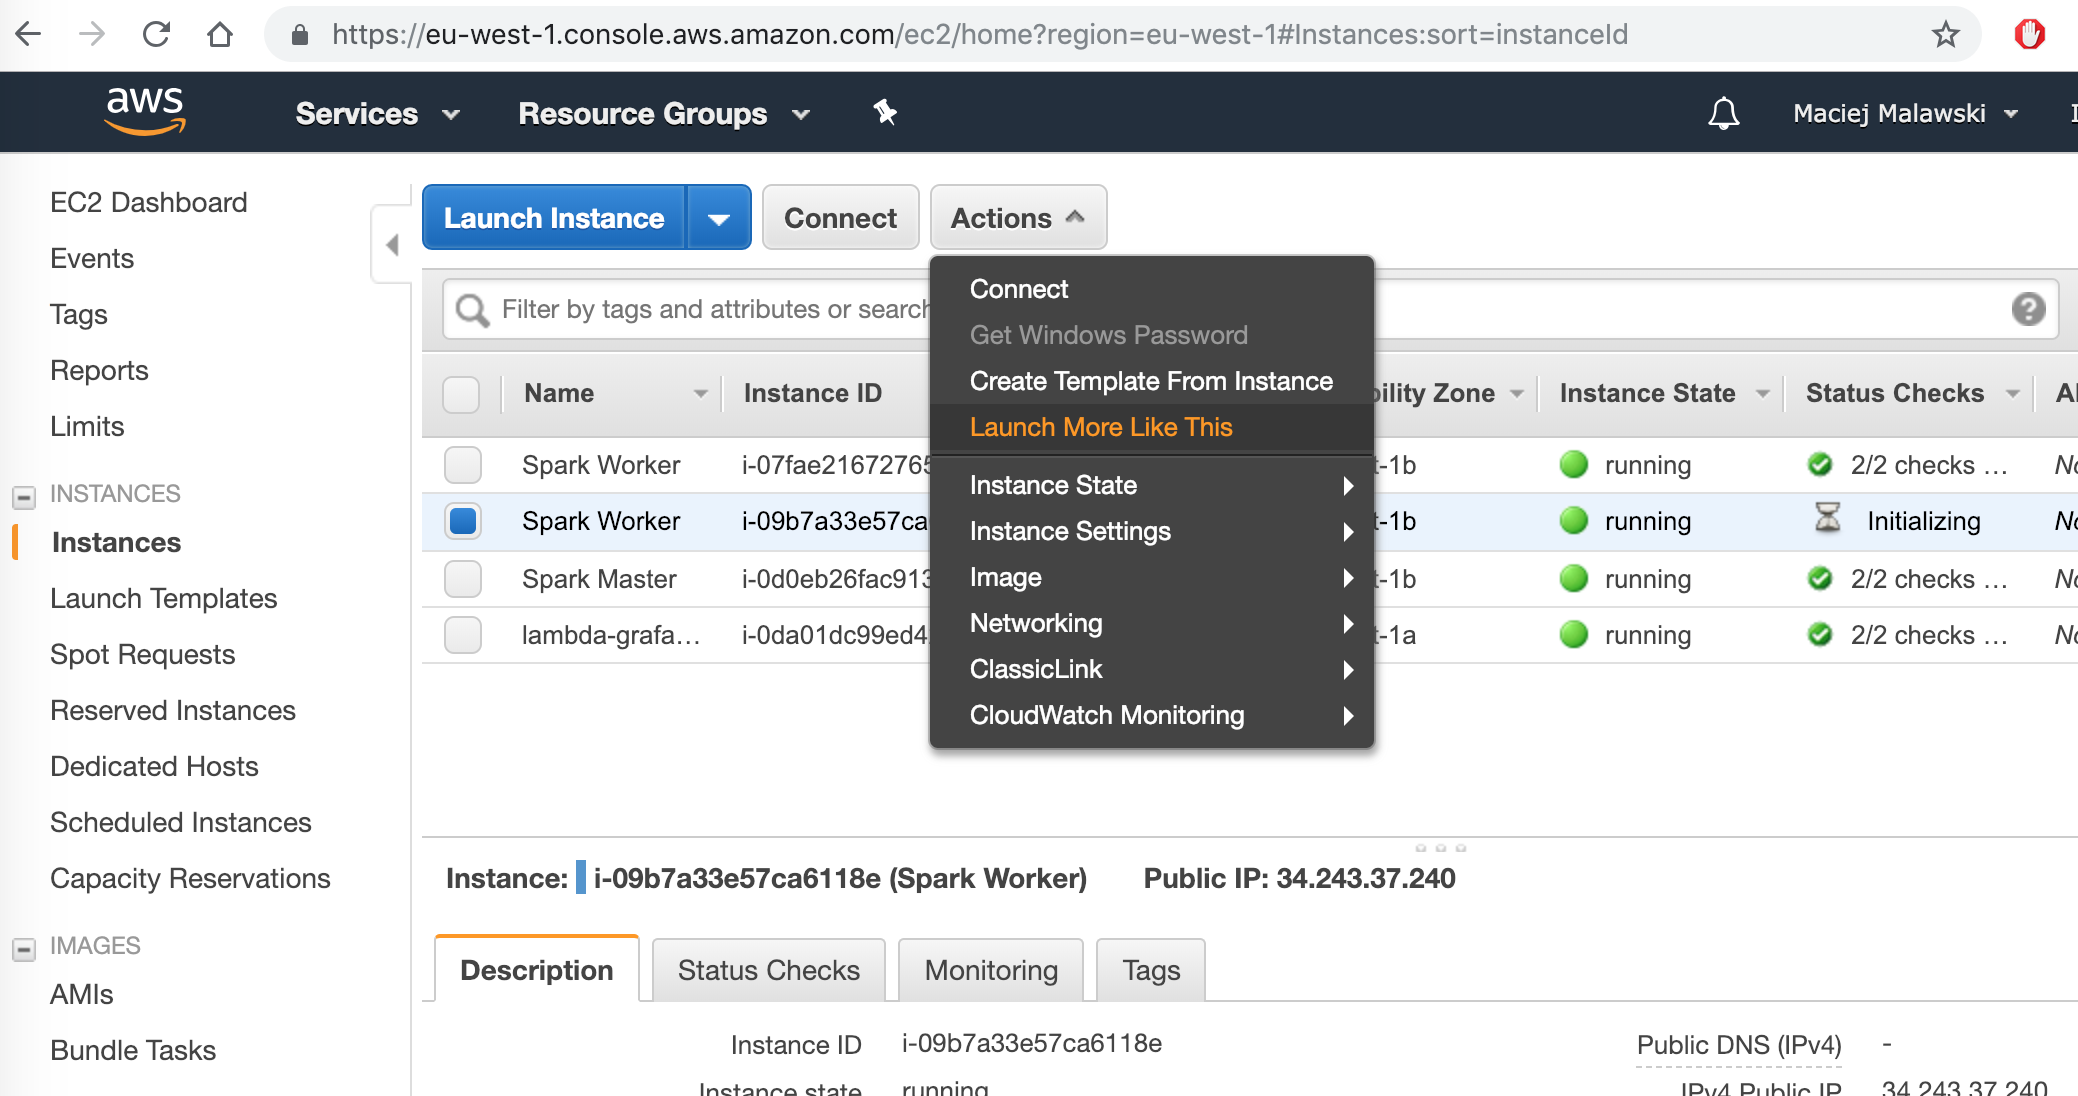

## 5. Measuring processing time

### 5.1 Spark UI

One way to measure how long it takes to complete a task, is to use Spark UI running on port 4040:

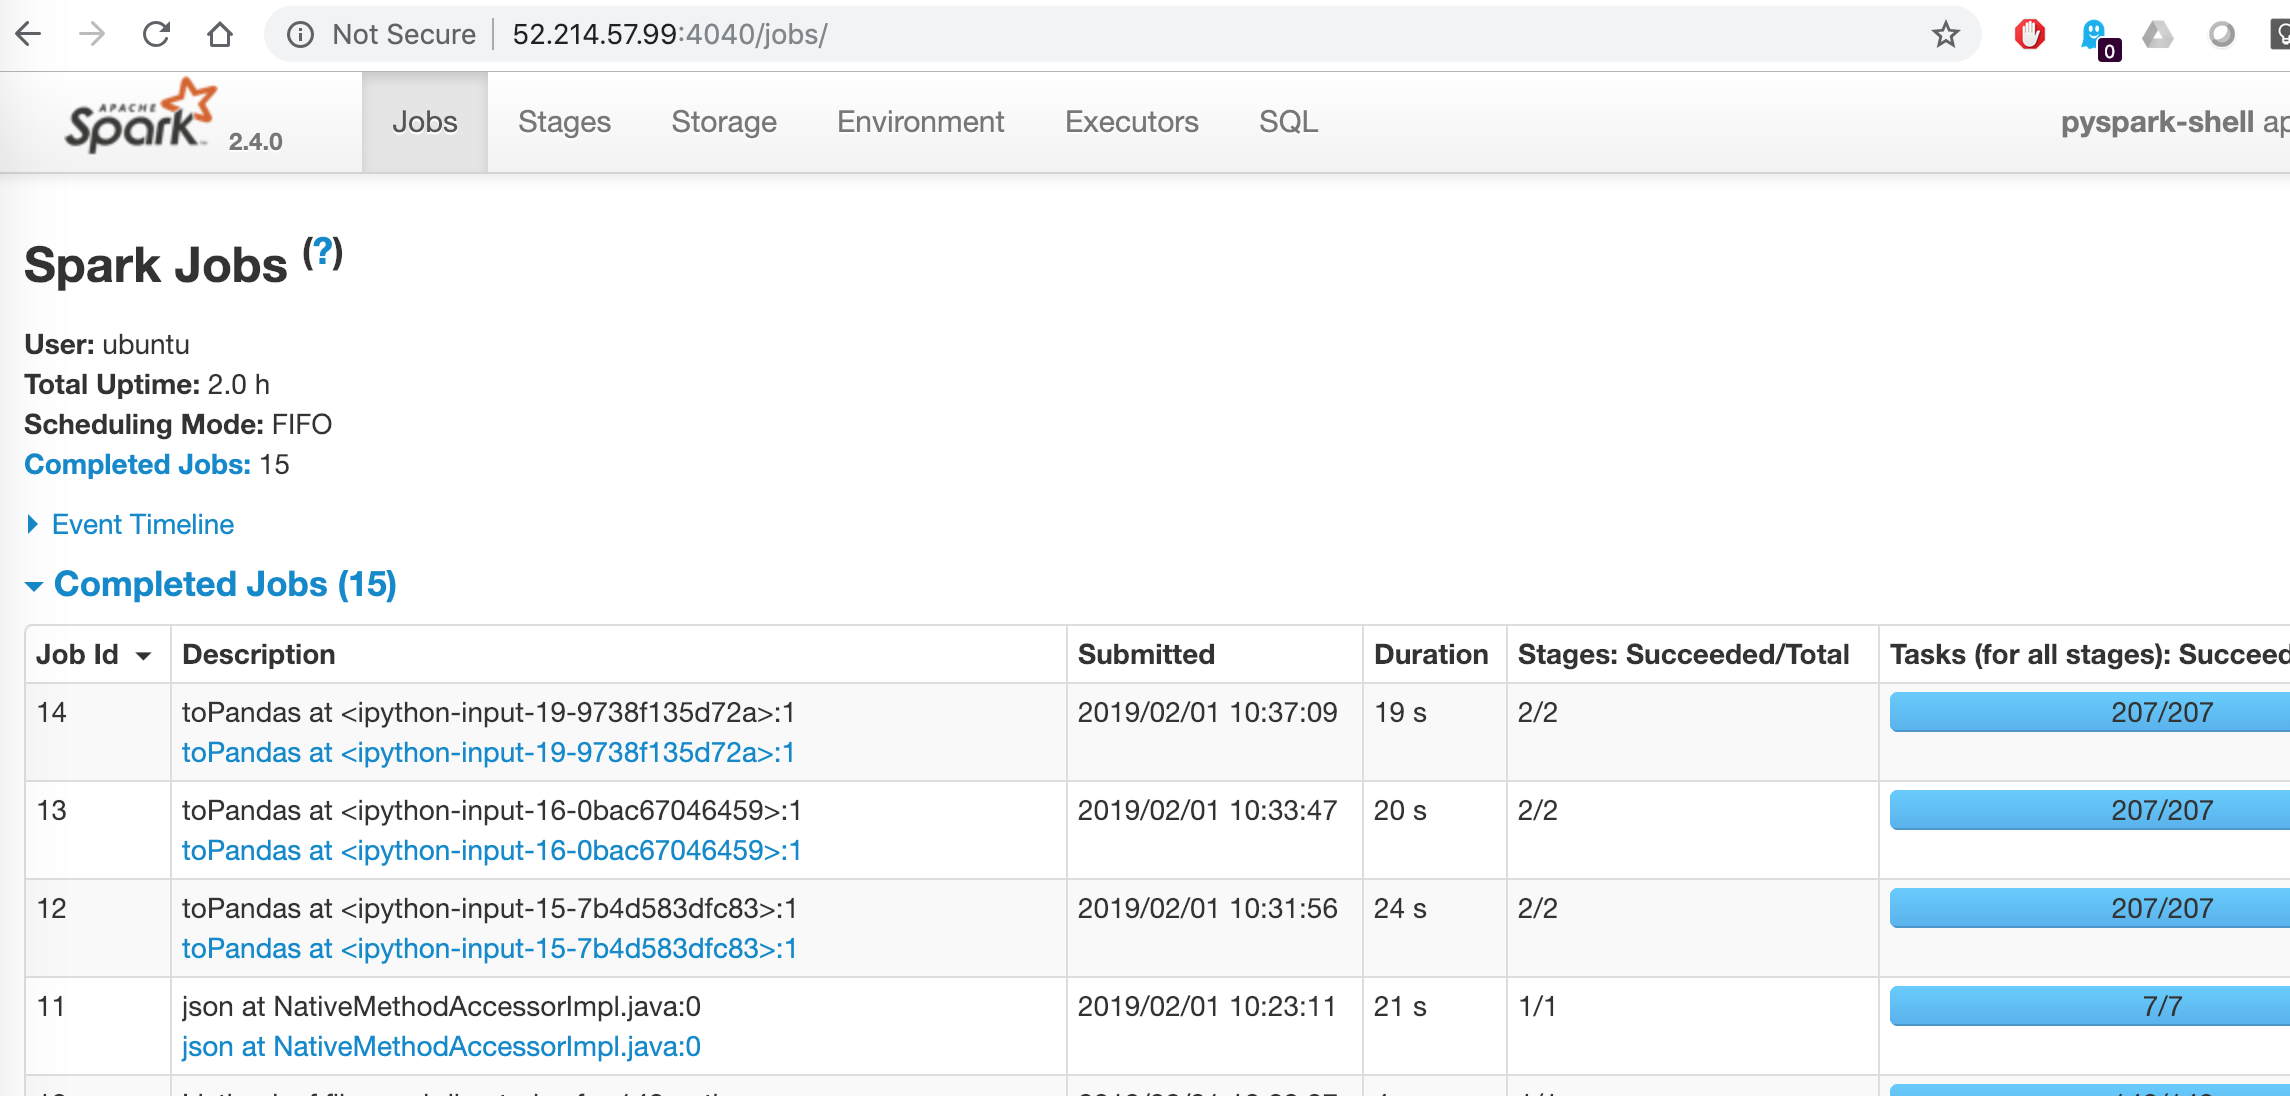

### 5.2 Cell run time

Another way is to use ``time`` magic in Jupyter. 
Wall time is the interesting output, since CPU time is onlythe Spark Driver execution time, not the whole cluster.

In [12]:
%%time
smog_df.select('parameter').distinct().toPandas()

CPU times: user 8.81 ms, sys: 0 ns, total: 8.81 ms
Wall time: 19.7 s


parameter
0        bc
1       so2
2        co
3        o3
4      pm10
5       no2
6      pm25

## 6. Shutting down the Spark Cluster

### 6.1 Deleting the stack using cloud formation

In the stack view: https://eu-west-1.console.aws.amazon.com/cloudformation/home?region=eu-west-1#/stacks
we can select and delete the stack:

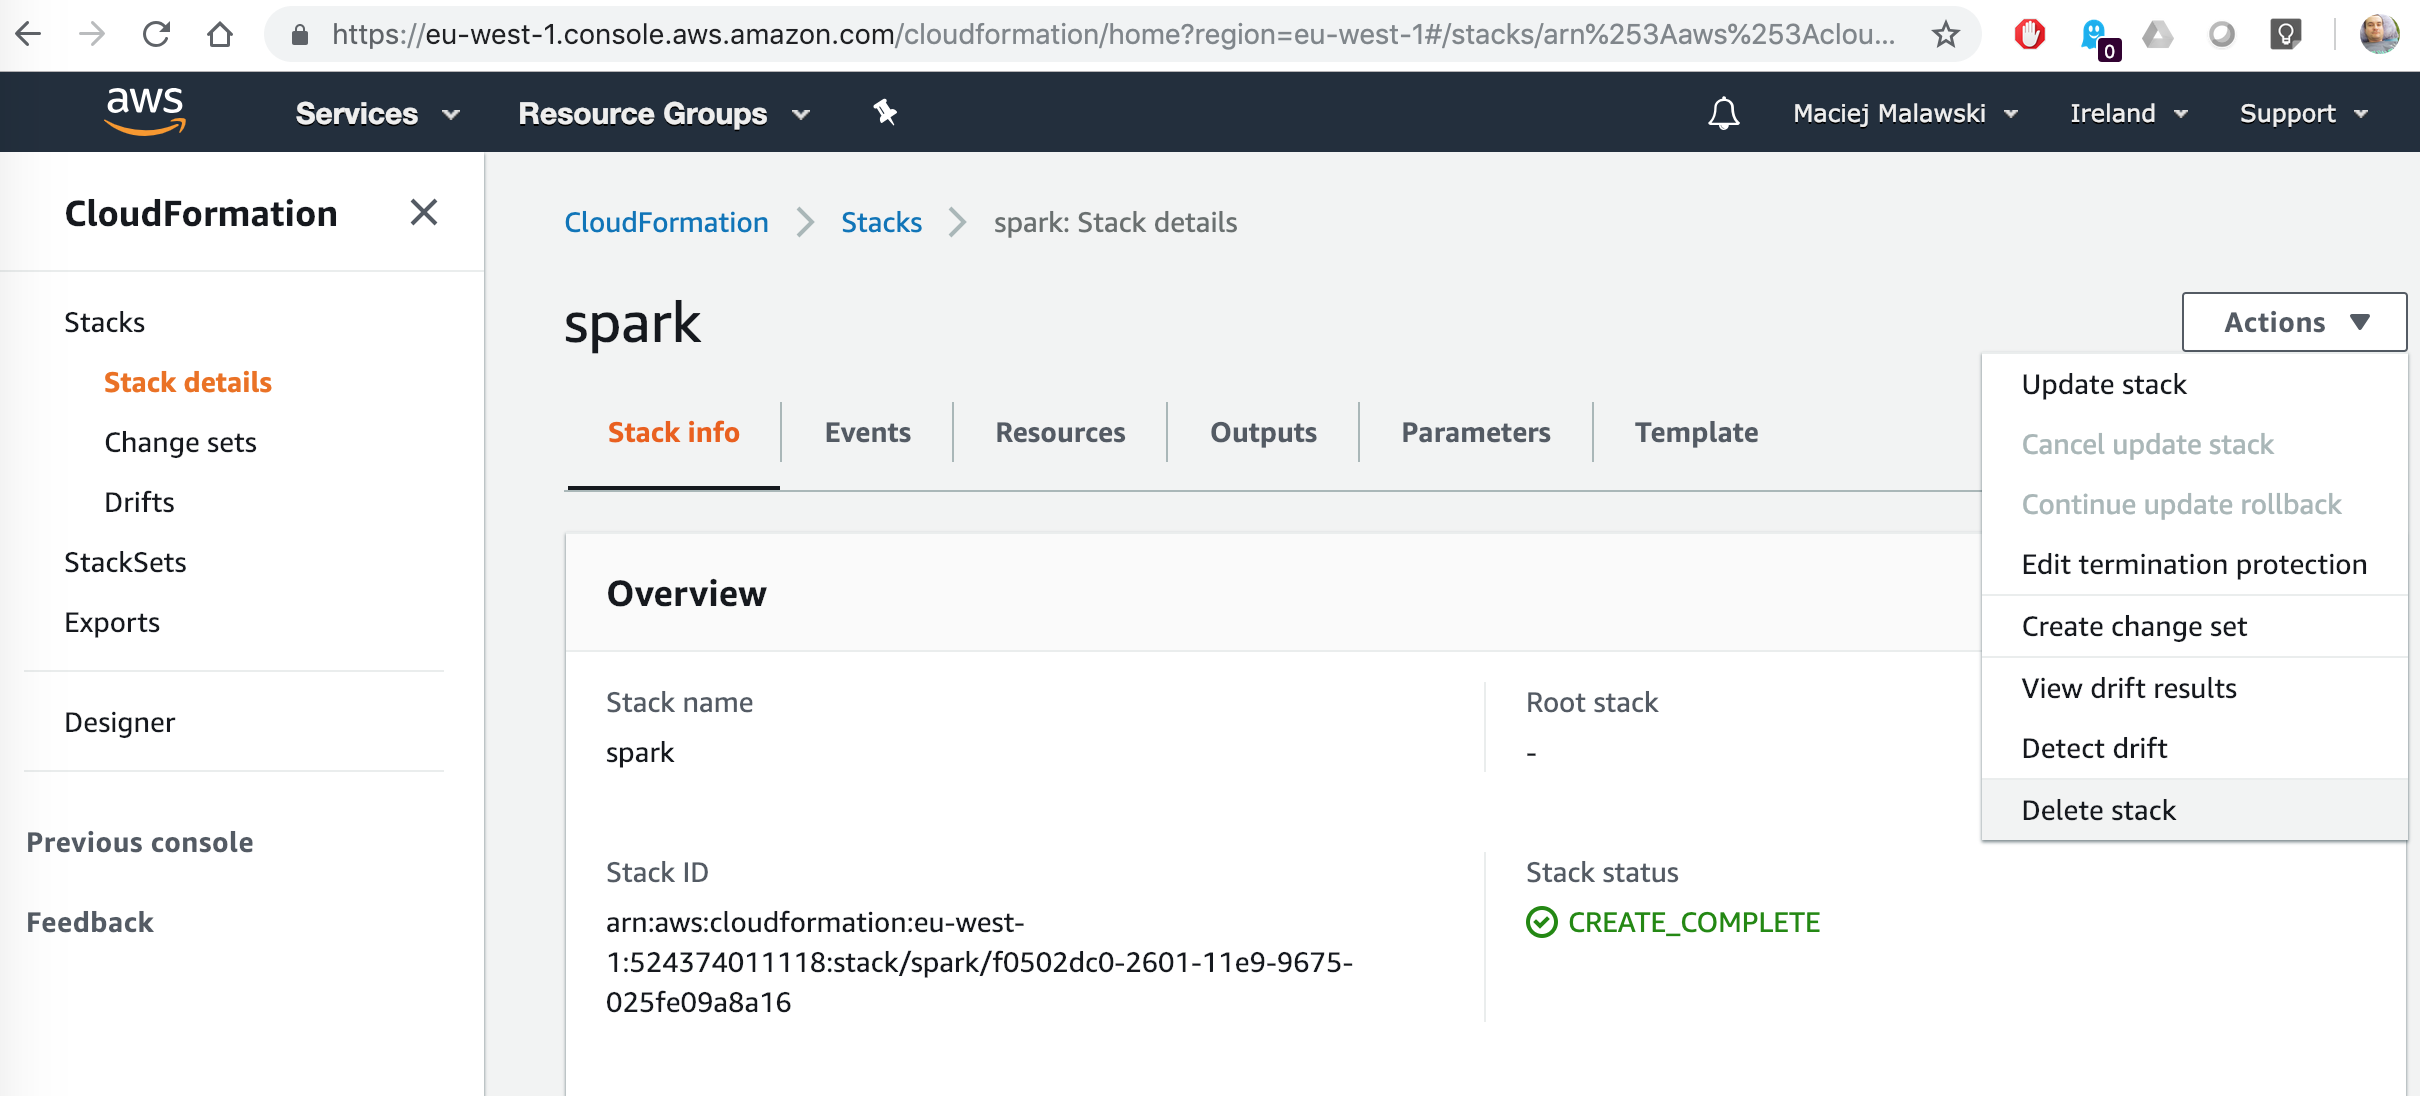

### Deleting worker VM Instances

Please remember to delete all the Workers that were cloned manually!

To do this, use the AWS EC2 console:

https://eu-west-1.console.aws.amazon.com/ec2/v2/home?region=eu-west-1#Instances:sort=instanceId

and terminate all the remaining workers.